## Importing Libraries and Data

In [3]:
# Importing packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
!pip3 install seaborn geopy
import seaborn as sns
import plotly.express as px
from geopy.geocoders import Nominatim
import plotly.graph_objs as go




In [91]:
# Importing data
layoffs = pd.read_csv("/Users/charitrapy/Desktop/SMDM/Project/Final_Code/layoffs_dataset.csv")

layoffs.head()

,company,location,industry,total_laid_off,percentage_laid_off,date,stage,country,funds_raised
0,Included Health,SF Bay Area,Healthcare,NaN,0.06,2022-07-25,Series E,United States,272.0
1,10X Genomics,SF Bay Area,Healthcare,100.0,0.08,2022-08-04,Post-IPO,United States,242.0
2,1stdibs,New York City,Retail,70.0,0.17,2020-04-02,Series D,United States,253.0
3,2U,Washington D.C.,Education,NaN,0.20,2022-07-28,Post-IPO,United States,426.0
4,54gene,Washington D.C.,Healthcare,95.0,0.30,2022-08-29,Series B,United States,44.0


## Data Cleaning

In [92]:
# Checking for duplicates
layoffs[layoffs.duplicated()]

,company,location,industry,total_laid_off,percentage_laid_off,date,stage,country,funds_raised


In [93]:
# Removing duplicates
layoffs.drop_duplicates(inplace=True)

In [94]:
# Looking for missing values
layoffs.isna().sum()

company                  0
location                 0
industry                 1
total_laid_off         274
percentage_laid_off      0
date                     1
stage                    3
country                  0
funds_raised            79
dtype: int64

In [95]:
# There are only a few missing values for the industry column
layoffs[layoffs["industry"].isnull()]

,company,location,industry,total_laid_off,percentage_laid_off,date,stage,country,funds_raised
71,Bally's Interactive,Providence,NaN,NaN,0.15,2023-01-18,Post-IPO,United States,946.0


In [96]:
# Filling in industry NA's with correct data from doing a google search
layoffs.loc[layoffs["company"] == "DataRails", "industry"] = "Finance"
layoffs.loc[layoffs["company"] == "Motional", "industry"] = "Transportation"
layoffs.loc[layoffs["company"] == "Proton.ai", "industry"] = "Sales"
layoffs.loc[layoffs["company"] == "InfluxData", "industry"] = "Product"
layoffs.loc[layoffs["company"] == "AvantStay", "industry"] = "Travel"
layoffs.loc[layoffs["company"] == "Exodus", "industry"] = "Crypto"

In [97]:
# There are only 4 missing values in the stage column which I'm filling with 'Unknown'
layoffs["stage"] = layoffs["stage"].fillna("Unknown")

In [98]:
# Looking at the one observation with a NA in the date column
layoffs[layoffs["date"].isnull()]

,company,location,industry,total_laid_off,percentage_laid_off,date,stage,country,funds_raised
94,Blackbaud,Charleston,Other,500.0,0.14,NaN,Post-IPO,United States,NaN


In [99]:
# Removing this observation since it has too much missing data
layoffs = layoffs[layoffs.company != "Homebound"]

In [100]:
# Im interested in knowing how many employees were laid off or the precent of employees
# laid off so Im removing observations where both columns(total_laid_off and percentage_laid_off)
# since these will not be useful

bothNA = layoffs[["total_laid_off", "percentage_laid_off"]].isnull().all(axis=1)
layoffs = layoffs.loc[~bothNA, :]

In [101]:
# If a company is missing either total laid off or percentage laid off it can be
# calculated if the company shows up again in the dataset AND has both values populated.
# First I need to calculate total number of employees
layoffs["total_employees"] = layoffs["total_laid_off"] / layoffs["percentage_laid_off"]

In [102]:
# How many inf, NA or zero values in the newly created variable total_employees?

print(
    f" The number of total_employees observations with NA values is {sum(layoffs.total_employees.isna())}"
)
print(
    f" The number of total_employees observations with inf values is {np.isinf(layoffs['total_employees']).values.sum()}"
)
print(
    f" The number of total_employee observations with 0 total employees {(layoffs['total_employees'] == 0).sum()}"
)

 The number of total_employees observations with NA values is 274
 The number of total_employees observations with inf values is 1
 The number of total_employee observations with 0 total employees 0


In [103]:
# replacing inf values with NA to make it uniform
layoffs = layoffs.replace([np.inf, -np.inf], np.nan)

In [104]:
# If a company has a missing value in the newly created total employees column, I'm
# going to fill it with the value from a differrent row where the total employee
# value is not an NA.
layoffs["total_employees"] = layoffs["total_employees"].fillna(
    layoffs.groupby("company")["total_employees"].transform("mean")
)

In [105]:
# Using the total_employees column to calculate the percentage_laid off column where
# companies show up more than once and it this column can be calculated

layoffs["percentage_laid_off"] = layoffs.apply(
    lambda row: row["total_laid_off"] / row["total_employees"]
    if np.isnan(row["percentage_laid_off"])
    else row["percentage_laid_off"],
    axis=1,
)

# This results in 70 less missing values in percentage_laid_off (317-247)
layoffs.isna().sum()

company                  0
location                 0
industry                 1
total_laid_off         274
percentage_laid_off      0
date                     1
stage                    0
country                  0
funds_raised            79
total_employees        244
dtype: int64

In [106]:
# fill the total_laid_off NA values with percentage_laid_off values multiplied by total_employees values
# for companies where I know the total amount of employees
layoffs["total_laid_off"] = layoffs.apply(
    lambda row: row["percentage_laid_off"] * row["total_employees"]
    if np.isnan(row["total_laid_off"])
    else row["total_laid_off"],
    axis=1,
)

# This results in 23 less missing values in the total laid off column (277-254)
layoffs.isna().sum()

company                  0
location                 0
industry                 1
total_laid_off         243
percentage_laid_off      0
date                     1
stage                    0
country                  0
funds_raised            79
total_employees        244
dtype: int64

## Feature Engineering Time Data

In [107]:
# Converting date column to pandas datetime series and adding month, year, and month_year column rows
layoffs['date'] = pd.to_datetime(layoffs['date'])
layoffs['month'] = layoffs['date'].dt.month
layoffs['year'] = layoffs['date'].dt.year
layoffs['month_year'] = layoffs['date'].dt.strftime('%B-%Y')
layoffs['quarter'] = layoffs['date'].dt.to_period('Q')

# And changing the month and year columns to objects for categorical visualizations
layoffs.loc[:, 'year'] = layoffs['year'].astype(str)
layoffs.loc[:, 'month'] = layoffs['month'].astype(str)



## Creating Dataframes for Different Visualizations

In [108]:
# There are still a lot of NA's so filling them in with mean values wouldnt be feasible
# The Na's seem to be random so Im going to make 3 different dataframes and decide later
# which is the best df to use for what is trying to be accomplished.

# Creating a dataframe where observations are removed with missing values in
# the total_laid_off column
layoffs_total = layoffs.dropna(subset=['total_laid_off'])

# Dataframe where observations with missing values in percentage_laid_off are removed
layoffs_perc = layoffs.dropna(subset=["percentage_laid_off"])

# Dataframe where observations with missing values in total_employees are removed
layoffs_emp = layoffs.dropna(subset=["total_employees"])

# Dataframe where all observations with a missing value are removed
layoffs_no_na = layoffs.dropna()


## Visuals

In [109]:
# Start by looking at layoffs by the year they occcured

# Group the 'layoffs_total' DataFrame by 'year' and sum the 'total_laid_off' values for each year
df_layoffs_year = layoffs_total.groupby('year',as_index=False)['total_laid_off'].sum()

# Create a bar chart using Plotly Express, with 'year' on the x-axis and 'total_laid_off' on the y-axis
fig = px.bar(df_layoffs_year, x='year', y='total_laid_off',
       text_auto='.5s', # Add text labels to the bars, formatted to show only 1 decimal place
       template='simple_white', # Use a simple white template for the chart
       title="Layoffs by Year", # Set the title of the chart
       category_orders={'year': ['2020', '2021', '2022', '2023']}, # Set the order of the 'year' values on the x-axis
       labels={'year': '', 'total_laid_off':'Amount of Layoffs'}) # Set the labels for the x and y axes

# Move the text labels outside the bars to improve readability
fig.update_traces(textposition='outside')

# Center the title of the chart
fig.update_layout(title_x=0.5)


In [110]:
# Visualizing layoffs by quarter

# Grouping layoffs by quarter
df_layoffs_quarter = layoffs_total.groupby("quarter", as_index=False)[
    "total_laid_off"
].sum()

# Adding the date column back in for time series bar chart since 'quarter' object type is period[Q-DEC]
df_layoffs_quarter["date"] = pd.PeriodIndex(
    df_layoffs_quarter["quarter"], freq="Q"
).strftime("%m-%Y")


# displaying layoffs by quarter.  Will improve later if I end up using it
fig = px.bar(df_layoffs_quarter, x="date", y="total_laid_off")
fig.show()

In [111]:
# taking a look at when layoffs occured by using a bubble scatterplot

fig = px.scatter(
    layoffs_total,
    x="date",
    y="total_laid_off",
    template="presentation",
    labels={"date": "", "total_laid_off": "Amount of Layoffs"},
    title="Layoffs from 2020 until 2023",
)
fig.update_xaxes(dtick="M11",)

fig.show()

In [112]:
# Looking at layoffs by month with a bar chart

fig = px.bar(
    layoffs_total.sort_values(by="date", ascending=True),
    x="month_year",
    y="total_laid_off",
    template="ggplot2",
    title="Layoff Timeline",
    labels={"month_year": "", "total_laid_off": "Total Layoffs"},
)
fig.update_layout(title_x=0.5)
fig.show()

In [113]:
industry_list = layoffs['industry'].unique()
total_layoff_sum = layoffs['total_laid_off'].sum()
sum_of_total_laid_off_list = []
for industry in industry_list:
    industry_sum = layoffs.loc[layoffs["industry"] == industry, "total_laid_off"].sum()
    percent = round(( industry_sum / total_layoff_sum) * 100, 2)
    yaxis_label = str(industry) + " - " + str(percent) + " % "
    sum_of_total_laid_off_list.append([industry, industry_sum, yaxis_label])

industry_laidoff_df = pd.DataFrame(sum_of_total_laid_off_list, columns=['Industry', 'Total_Laid_Off', 'Y'])
industry_laidoff_df = industry_laidoff_df[industry_laidoff_df['Total_Laid_Off'] > 99]
industry_laidoff_df = industry_laidoff_df.sort_values(by="Total_Laid_Off", ascending=False)
print(industry_laidoff_df)

          Industry  Total_Laid_Off                         Y
12        Consumer    37360.000000       Consumer - 15.37 % 
1           Retail    24050.777778          Retail - 9.89 % 
27        Hardware    22370.000000         Hardware - 9.2 % 
9   Transportation    21126.000000  Transportation - 8.69 % 
13           Other    20140.333333           Other - 8.29 % 
8          Finance    13987.000000         Finance - 5.75 % 
16     Real Estate    13194.666667     Real Estate - 5.43 % 
3            Sales    12347.000000           Sales - 5.08 % 
0       Healthcare     9350.600000      Healthcare - 3.85 % 
4             Food     8634.000000            Food - 3.55 % 
25         Fitness     6901.333333         Fitness - 2.84 % 
6           Crypto     6190.389610          Crypto - 2.55 % 
10          Travel     6188.000000          Travel - 2.55 % 
7        Marketing     5457.290909       Marketing - 2.25 % 
20  Infrastructure     5361.000000  Infrastructure - 2.21 % 
17        Security     4

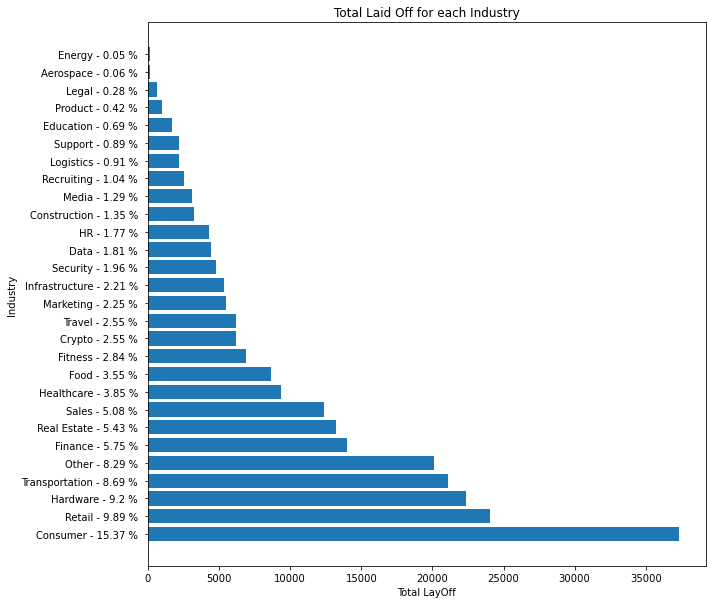

In [114]:
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)
plt.title("Total Laid Off for each Industry")
plt.xlabel("Total LayOff")
plt.ylabel("Industry")
plt.barh(industry_laidoff_df["Y"], industry_laidoff_df["Total_Laid_Off"])
plt.show()

In [115]:
# Layoffs by year and industry
# df_ind_yr = layoffs_total.groupby(["industry", "year"]).sum()
df_ind_yr = layoffs_total.groupby(["industry", "year"])["total_laid_off"].sum()

df_ind_yr = df_ind_yr.reset_index()

# Visualizing with a stacked bar chart
fig = px.bar(
    df_ind_yr.sort_values(by=["total_laid_off"], ascending=False),
    x="industry",
    y="total_laid_off",
    color="year",
    height=700,
    template="ggplot2",
    title="Layoffs by Year and Industry",
    category_orders={"year": ["2020", "2021", "2022", "2023"]},
    labels={"industry": "Industry", "total_laid_off": "Total Layoffs"},
)
fig.update_layout(title_x=0.5)
fig.show()

In [116]:
# Layoffs by year and industry with a side by side bar chart instead of stacked

fig = px.bar(
    df_ind_yr.sort_values(by=["total_laid_off"], ascending=False),
    x="industry",
    y="total_laid_off",
    color="year",
    barmode="group",
    height=700,
    template="ggplot2",
    title="Layoffs by Year and Industry",
    labels={"industry": "Industry", "total_laid_off": "Total Layoffs"},
    category_orders={"year": ["2020", "2021", "2022", "2023"]},
)
fig.update_layout(title_x=0.5)
fig.show()

In [117]:
# There is only a few weeks of data for Jan so let's add those layoffs to 2022 to see if
# it changes the outcome much

df_23is22 = layoffs_total.copy()
df_23is22["year"].mask(df_23is22["year"] == "2023", "2022", inplace=True)
df2_20_23 = df_23is22[df_23is22["year"] != "2021"]
df2_20_23.year.unique()

array(['2022.0', '2020.0', '2023.0', '2021.0', 'nan'], dtype=object)

In [118]:
# take a look at the distribution of the percentage of layoffs in a company.  If a company is laying
# off a small percentage of their staff they could just be letting go of their worst performers or extra
# people hired in 2021

fig = px.box(
    layoffs_perc,
    x="year",
    y="percentage_laid_off",
    color="year",
    category_orders={"year": ["2020", "2021", "2022", "2023"]},
    template="seaborn",
    title="Percent of Company's Workforce Laid Off by Year",
    labels={"percentage_laid_off": "Percent of Company Laid Off", "year": "Year"},
)
fig.layout.yaxis.tickformat = ",.0%"
fig.layout.update(showlegend=False)

fig.show()

In [119]:
# Creating a violin chart with the same parameters as the above boxplot to compare which is a better
# visual

fig = px.violin(layoffs_perc, x="year", y="percentage_laid_off", box = True, points = 'all')
fig.show()



In [120]:
# Creating a box plot to look at percentage of a companies workforce is laid off based on what stage of
# funding for the company

fig = px.box(layoffs_perc, x="stage", y="percentage_laid_off")
fig.show()

In [121]:
# The boxplot above has too much going on so Im creating another with 5 well known stages in order

df_perc_stage = layoffs_perc.loc[layoffs_perc['stage'].isin(['Seed','IPO', 'Series A', 'Series B', 'Series C'])]
fig = px.box(df_perc_stage, x="stage", y="percentage_laid_off",
            title = 'Percent of Layoffs per Company based on Funding Stage',
                          color='stage',
            template = 'seaborn',
            labels={'percentage_laid_off': 'Percent of Company Laid Off', 'stage':'Stage'},
            category_orders = {'stage': ['Seed', 'Series A', 'Series B', 'Series C', 'IPO']})
fig.layout.yaxis.tickformat = ',.0%'
fig.layout.update(showlegend=False)
fig.show()


In [122]:
sfbay_df = layoffs[layoffs['location'] == "SF Bay Area"]
total_sfbay_layoff = sfbay_df['total_laid_off'].sum()

industry_list = sfbay_df['industry'].unique()
industry_list

sum_of_total_laid_off_list = []
for industry in industry_list:
    industry_sum = sfbay_df.loc[sfbay_df["industry"] == industry, "total_laid_off"].sum()
    percent = round((industry_sum / total_sfbay_layoff) * 100, 2)
    yaxis_label =  str(industry) + " - " + str(percent) + " % "
    sum_of_total_laid_off_list.append([industry, industry_sum, yaxis_label])

industrywise_laidoff_df = pd.DataFrame(sum_of_total_laid_off_list, columns=['Industry', 'Total_Laid_Off', 'Y'])
industrywise_laidoff_df = industrywise_laidoff_df[industrywise_laidoff_df['Total_Laid_Off'] > 0]
industrywise_laidoff_df = industrywise_laidoff_df.sort_values(by="Total_Laid_Off", ascending=False)
print(industrywise_laidoff_df)

          Industry  Total_Laid_Off                         Y
22        Consumer    33669.000000       Consumer - 27.83 % 
5   Transportation    11813.000000  Transportation - 9.76 % 
1            Sales    11639.000000           Sales - 9.62 % 
4          Finance    11442.000000         Finance - 9.46 % 
12           Other     6347.000000           Other - 5.25 % 
14          Retail     5812.777778           Retail - 4.8 % 
19  Infrastructure     4855.000000  Infrastructure - 4.01 % 
25        Hardware     4620.000000        Hardware - 3.82 % 
3           Crypto     3368.000000          Crypto - 2.78 % 
6           Travel     3091.000000          Travel - 2.55 % 
24    Construction     3090.000000    Construction - 2.55 % 
0       Healthcare     2761.666667      Healthcare - 2.28 % 
8             Data     2459.000000            Data - 2.03 % 
20            Food     2020.000000            Food - 1.67 % 
10     Real Estate     1927.666667     Real Estate - 1.59 % 
21      Recruiting     1

<BarContainer object of 27 artists>

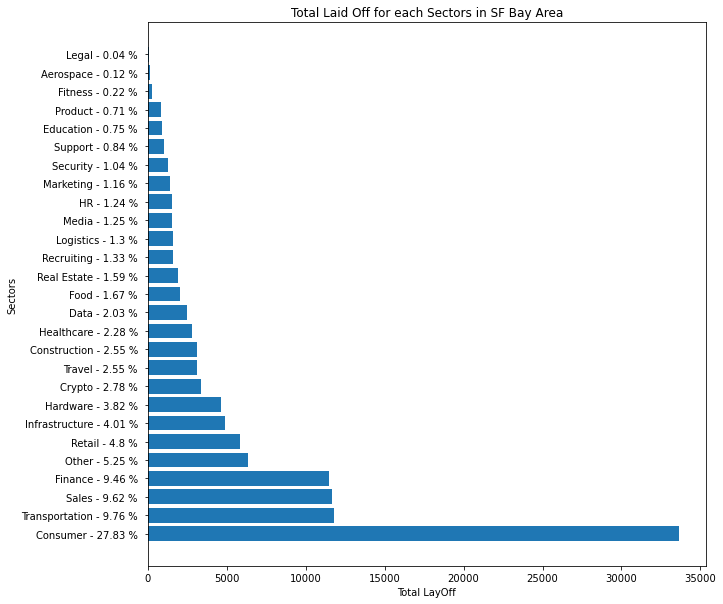

In [123]:
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)
plt.title("Total Laid Off for each Sectors in SF Bay Area")
plt.xlabel("Total LayOff")
plt.ylabel("Sectors")
plt.barh(industrywise_laidoff_df["Y"], industrywise_laidoff_df["Total_Laid_Off"])

In [124]:
newyork_df = layoffs[layoffs['location'] == "New York"]
sfbayarea_df = layoffs[layoffs['location'] == "SF Bay Area"] 
seattle_df = layoffs[layoffs['location'] == "Seattle"] 

combined_us_df = pd.concat([newyork_df, sfbayarea_df, seattle_df], ignore_index=True, axis=0) 
total_combined_layoff = combined_us_df['total_laid_off'].sum()

industry_list = combined_us_df['industry'].unique()
industry_list

sum_of_total_laid_off_list = []
for industry in industry_list:
    industry_sum = combined_us_df.loc[combined_us_df["industry"] == industry, "total_laid_off"].sum()
    percent = round((industry_sum / total_combined_layoff) * 100, 2)
    yaxis_label =  str(industry) + " - " + str(percent) + " % "
    sum_of_total_laid_off_list.append([industry, industry_sum, yaxis_label])

industrywise_laidoff_df = pd.DataFrame(sum_of_total_laid_off_list, columns=['Industry', 'Total_Laid_Off', 'Y'])
industrywise_laidoff_df = industrywise_laidoff_df[industrywise_laidoff_df['Total_Laid_Off'] > 0]
industrywise_laidoff_df = industrywise_laidoff_df.sort_values(by="Total_Laid_Off", ascending=False)
print(industrywise_laidoff_df)

          Industry  Total_Laid_Off                         Y
22        Consumer    33863.000000       Consumer - 22.97 % 
12           Other    16432.000000          Other - 11.14 % 
14          Retail    15999.777778         Retail - 10.85 % 
5   Transportation    11976.000000  Transportation - 8.12 % 
1            Sales    11869.000000           Sales - 8.05 % 
4          Finance    11482.000000         Finance - 7.79 % 
10     Real Estate     6648.666667     Real Estate - 4.51 % 
19  Infrastructure     4861.000000   Infrastructure - 3.3 % 
25        Hardware     4620.000000        Hardware - 3.13 % 
3           Crypto     3368.000000          Crypto - 2.28 % 
6           Travel     3091.000000           Travel - 2.1 % 
24    Construction     3090.000000     Construction - 2.1 % 
0       Healthcare     2944.666667       Healthcare - 2.0 % 
8             Data     2609.000000            Data - 1.77 % 
20            Food     2020.000000            Food - 1.37 % 
16       Logistics     1

<BarContainer object of 27 artists>

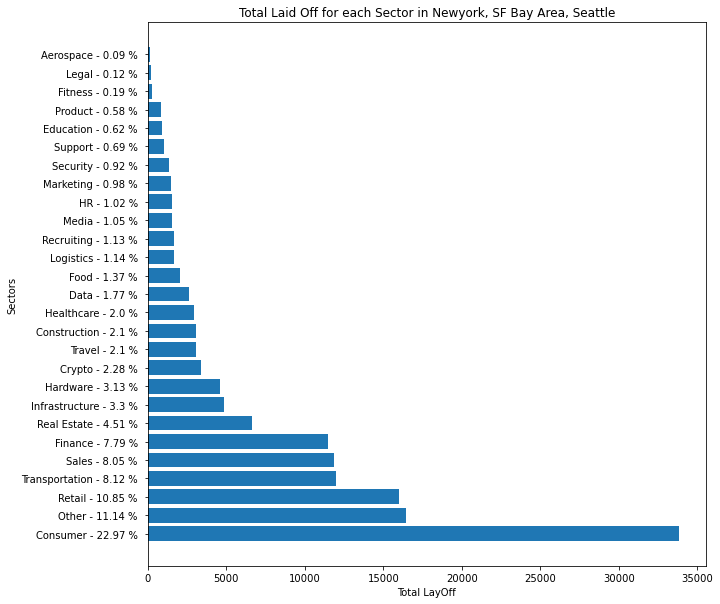

In [125]:
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)
plt.title("Total Laid Off for each Sector in Newyork, SF Bay Area, Seattle")
plt.xlabel("Total LayOff")
plt.ylabel("Sectors")
plt.barh(industrywise_laidoff_df["Y"], industrywise_laidoff_df["Total_Laid_Off"])

In [126]:
# Cleaning the cleaned_df for column "percentage_laid_off" as it still contains some NaN values
cleaned_percentage_laid_off_df = layoffs.drop(layoffs[layoffs['percentage_laid_off'].isna() == True].index)
cleaned_percentage_laid_off_df = cleaned_percentage_laid_off_df.sort_values(by='percentage_laid_off', ascending=False)
cleaned_percentage_laid_off_df

,company,location,industry,total_laid_off,percentage_laid_off,date,stage,country,funds_raised,total_employees,month,year,month_year,quarter
61,Automatic,SF Bay Area,Transportation,NaN,1.00,2020-05-01,Acquired,United States,24.0,NaN,5.0,2020.0,May-2020,2020Q2
806,Service,Los Angeles,Travel,NaN,1.00,2020-03-20,Seed,United States,5.0,NaN,3.0,2020.0,March-2020,2020Q1
935,Toucan,Los Angeles,Education,NaN,1.00,2023-03-09,Series A,United States,NaN,NaN,3.0,2023.0,March-2023,2023Q1
537,Locomation,Pittsburgh,Transportation,NaN,1.00,2023-02-22,Seed,United States,57.0,NaN,2.0,2023.0,February-2023,2023Q1
862,Stay Alfred,Spokane,Travel,221.0,1.00,2020-05-20,Series B,United States,62.0,221.0,5.0,2020.0,May-2020,2020Q2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
614,Netflix,SF Bay Area,Media,150.0,0.01,2022-05-17,Post-IPO,United States,121900.0,15000.0,5.0,2022.0,May-2022,2022Q2
787,Salesforce,SF Bay Area,Sales,1000.0,0.01,2022-11-07,Post-IPO,United States,65.0,100000.0,11.0,2022.0,November-2022,2022Q4
307,F5,Seattle,Security,100.0,0.01,2022-10-21,Post-IPO,United States,NaN,10000.0,10.0,2022.0,October-2022,2022Q4
849,Splunk,SF Bay Area,Data,70.0,0.01,2020-06-16,Post-IPO,United States,40.0,7000.0,6.0,2020.0,June-2020,2020Q2


In [127]:
company_us_list = layoffs['company'].unique()

sum_of_total_laid_off_list = []
for company in company_us_list:
    company_sum = layoffs.loc[layoffs['company'] == company, 'total_laid_off'].sum()
    percent = round((company_sum / total_layoff_sum) * 100, 2)
    yaxis_label = str(company) + " - " + str(percent) + " % "
    sum_of_total_laid_off_list.append([company, company_sum, yaxis_label])

company_us_df = pd.DataFrame(sum_of_total_laid_off_list, columns=['Company', 'Total_Laid_Off', 'Y'])
company_us_df = company_us_df[company_us_df['Total_Laid_Off'] > 0]
company_us_df = company_us_df.sort_values(by='Total_Laid_Off', ascending=False)
print(company_us_df)

          Company  Total_Laid_Off                      Y
326        Google         12000.0       Google - 4.94 % 
491          Meta         11000.0         Meta - 4.53 % 
670    Salesforce         10000.0   Salesforce - 4.11 % 
25         Amazon         10000.0       Amazon - 4.11 % 
494     Microsoft         10000.0    Microsoft - 4.11 % 
..            ...             ...                    ...
216    DialSource             5.0    DialSource - 0.0 % 
759  Synergysuite             5.0  Synergysuite - 0.0 % 
288     Flytedesk             4.0     Flytedesk - 0.0 % 
726         Spyce             4.0         Spyce - 0.0 % 
109        Branch             3.0        Branch - 0.0 % 

[677 rows x 3 columns]


<BarContainer object of 50 artists>

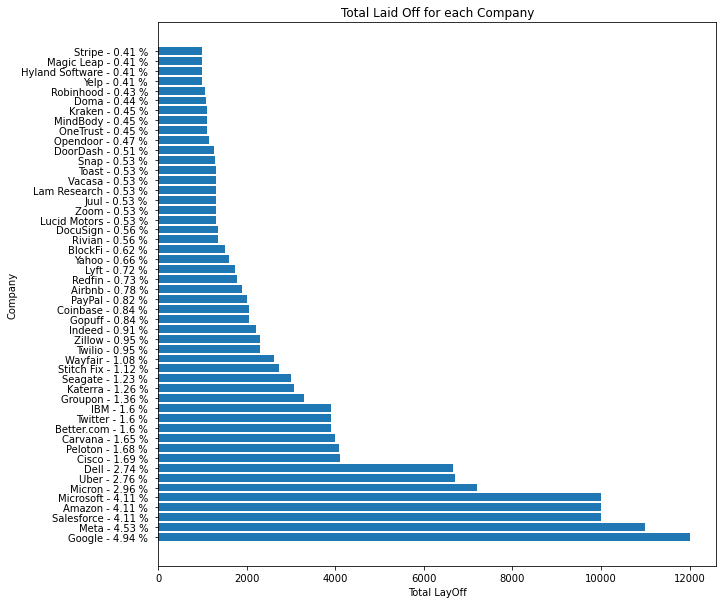

In [128]:
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)
plt.title("Total Laid Off for each Company")
plt.xlabel("Total LayOff")
plt.ylabel("Company")
plt.barh(company_us_df['Y'][:50], company_us_df['Total_Laid_Off'][:50])

In [129]:
# Boxplot showing what percent of workforce is laid off by company location.

fig = px.box(layoffs_perc, x="country", y="percentage_laid_off")
fig.show()

In [130]:
us_pecentage_laidoff_df = cleaned_percentage_laid_off_df[cleaned_percentage_laid_off_df['country'] == "United States"]
company_list = us_pecentage_laidoff_df['company'].unique()

temp_list = []
for company in company_list:
    company_sum = us_pecentage_laidoff_df.loc[us_pecentage_laidoff_df['company'] == company, 'percentage_laid_off'].sum()
    temp_list.append([company, company_sum])

companywise_percent_laidoff_df = pd.DataFrame(temp_list, columns=['Company', 'Percentage_Laid_Off'])
companywise_percent_laidoff_df = companywise_percent_laidoff_df.sort_values(by='Percentage_Laid_Off', ascending=False)
print(companywise_percent_laidoff_df)

               Company  Percentage_Laid_Off
1              Service                 2.00
5                Medly                 1.66
82              Rubius                 1.57
30            The Wing                 1.50
78   Pear Therapeutics                 1.45
..                 ...                  ...
902           Palantir                 0.02
903           Autodesk                 0.02
904                N26                 0.01
905                 F5                 0.01
906             TaskUs                 0.00

[907 rows x 2 columns]


<BarContainer object of 50 artists>

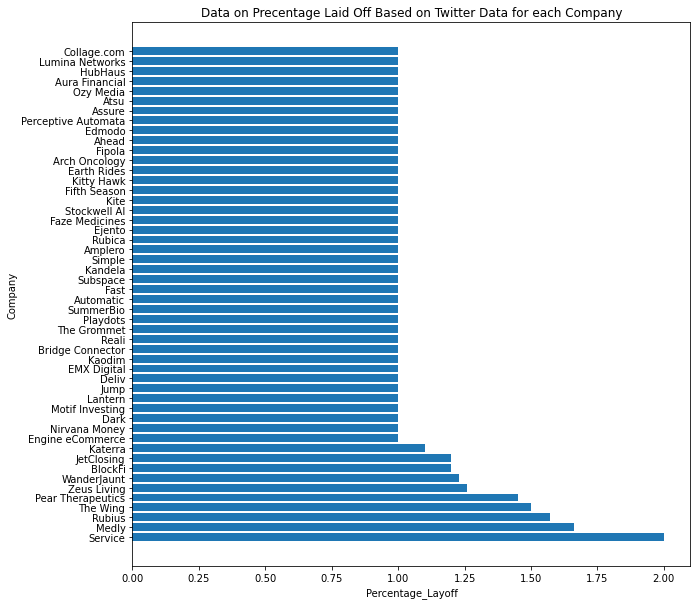

In [131]:
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)
plt.title("Data on Precentage Laid Off Based on Twitter Data for each Company")
plt.xlabel("Percentage_Layoff")
plt.ylabel("Company")
plt.barh(companywise_percent_laidoff_df['Company'][:50], companywise_percent_laidoff_df['Percentage_Laid_Off'][:50])

In [132]:
# look at the number of layoffs per location(city) and limit it to the top 15 cities
layoffs_loc = (
    layoffs_total.groupby("location", as_index=False)["total_laid_off"]
    .sum()
    .sort_values("total_laid_off", ascending=False)
    .head(15)
)
fig = px.bar(
    layoffs_loc,
    x="location",
    y="total_laid_off",
    text_auto=".4s",
    title="Layoffs per City",
    template="seaborn",
    labels={"total_laid_off": "Amount of Layoffs", "location": "City"},
)
fig.update_traces(textposition="outside")

In [133]:
# The 2 location bar charts would work better as a singular sunburst chart

df_city_country = (
    layoffs_total.groupby(["country", "location"], as_index=False)["total_laid_off"]
    .sum()
    .sort_values("total_laid_off", ascending=False)
)


fig = px.sunburst(
    df_city_country,
    path=["country", "location"],
    template="seaborn",
    values="total_laid_off",
)
fig.show()

/Users/charitrapy/opt/anaconda3/lib/python3.9/site-packages/plotly/express/_core.py:1637: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/charitrapy/opt/anaconda3/lib/python3.9/site-packages/plotly/express/_core.py:1637: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [134]:
# Previously looked at number of layoffs and now will look at the number companies
# in each industry that had layoffs

df_layoffs_co = (
    layoffs.groupby("industry")[["company"]]
    .nunique()
    .sort_values("company", ascending=False)
)
df_layoffs_co = df_layoffs_co.reset_index()
fig = px.bar(
    df_layoffs_co,
    x="industry",
    y="company",
    title="Number of Companies with Layoffs by Industry",
    template="seaborn",
    labels={"company": "Amount of Companies", "industry": "Industry"},
)
fig.update_traces(textposition="outside")

In [135]:
# Lookking at the number companies in each industry that had layoffs and seperate by year instead
# of total layoffs by industry

df_layoffs_co_yr = (
    layoffs.groupby(["industry", "year"])[["company"]]
    .nunique()
    .sort_values("company", ascending=False)
)
df_layoffs_co_yr = df_layoffs_co_yr.reset_index()
fig = px.bar(
    df_layoffs_co_yr.sort_values(by=["company"], ascending=False),
    x="industry",
    y="company",
    color="year",
    barmode="group",
    height=700,
    template="ggplot2",
    category_orders={"year": ["2020", "2021", "2022", "2023"]},
    title="Layoffs by Year and Industry",
    labels={"company": "Amount of Companies", "industry": "Industry"},
)
fig.update_layout(title_x=0.5)
fig.show()

In [136]:
# Showing the top 20 companies with the most layoffs by year of layoff


df_co_yr = (
    layoffs.groupby(["company", "year"])[["total_laid_off"]]
    .sum()
    .sort_values("total_laid_off", ascending=False)
    .head(30)
)
df_co_yr = df_co_yr.reset_index()
fig = px.bar(
    df_co_yr.sort_values(by=["total_laid_off"], ascending=True),
    x="company",
    y="total_laid_off",
    color="year",
    height=700,
    template="ggplot2",
    category_orders={"year": ["2020", "2021", "2022", "2023"]},
    title="Layoffs of top 20 Companies by Year",
    labels={"company": "Company", "total_laid_off": "Total Layoffs"},
)
fig.update_layout(title_x=0.5, xaxis={"categoryorder": "total descending"})
fig.show()

In [137]:
# Showing the top 20 companies with the most layoffs by year of layoff


df_co_yr = (
    layoffs.groupby(["company", "year"])[["total_laid_off"]]
    .sum()
    .sort_values("total_laid_off", ascending=False)
    .head(25)
)
df_co_yr = df_co_yr.reset_index()
fig = px.bar(
    df_co_yr.sort_values(by=["total_laid_off"], ascending=True),
    x="company",
    y="total_laid_off",
    color="year",
    height=700,
    template="ggplot2",
    category_orders={"year": ["2020", "2021", "2022", "2023"]},
    title="Companies with the Most Layoffs",
    labels={"company": "", "total_laid_off": "Total Layoffs", "year": "Year"},
)
fig.update_layout(title_x=0.5, xaxis={"categoryorder": "total descending"})
fig.show()

In [138]:
# Pie chart showing percentage of layoffs by industry although probaly wont use
df_ind_yr = layoffs_total.groupby(["industry", "year"])[["total_laid_off"]].sum()
df_ind_yr = df_ind_yr.reset_index()
fig = px.pie(
    df_ind_yr[df_ind_yr["year"].str.contains("2020")],
    values="total_laid_off",
    names="industry",
    title="Amount of Layoffs by Industry (2020)",
)
fig.show()

In [139]:
# Pie chart showing percentage of layoffs by industry in 2022
df_ind_yr = layoffs_total.groupby(["industry", "year"]).sum()
df_ind_yr = df_ind_yr.reset_index()
fig = px.pie(
    df_ind_yr[df_ind_yr["year"].str.contains("2022")],
    values="total_laid_off",
    names="industry",
    title="Amount of Layoffs by Industry (2022)",
)
fig.show()

In [140]:
# Pie chart showing percentage of layoffs by industry for all years

df_ind = layoffs_total.groupby(["industry"]).sum()
df_ind = df_ind_yr.reset_index()
fig = px.pie(
    df_ind_yr,
    values="total_laid_off",
    names="industry",
    title="Amount of Layoffs by Industry (2020-2023)",
)
fig.show()

In [141]:
# Bubble Scatterplot showing layoff timeline with the larger bubble equal to more layoffs
# and the y axis showing the percent of the company that was laid off

fig = px.scatter(
    layoffs_no_na,
    x="date",
    y="percentage_laid_off",
    size="total_laid_off",
    template="ggplot2",
    labels={"date": "", "total_laid_off": "Amount of Layoffs"},
    size_max=30,
    title="Layoffs from 2020 until 2023",
)
fig.update_xaxes(dtick="M11",)

fig.show()

In [142]:
df_3_ind = layoffs_total[
    layoffs_total["industry"].str.contains(
        "|".join(["Healthcare", "Crypto", "Education"])
    )
]

fig = px.scatter(
    df_3_ind,
    x="date",
    y="industry",
    size="total_laid_off",
    color="industry",
    template="gridon",
    labels={"date": "", "industry": ""},
    size_max=60,
    title="Layoff Timeline",
)
fig.update_xaxes(dtick="M11",)
fig.update_yaxes(gridcolor="lightsteelblue")
fig.layout.update(showlegend=False)
fig.show()

In [143]:
# Working with data to change size of bubbles.  If I want the difference to be greater between the smallest
# and largest bubbles I should be able to square the data.  And If I want the bubbles to be more similiar in
# size I can apply the square root to the data

# copy the data
df_max_scale = layoffs_total.copy()

# apply normalization techniques on Column 1 to increase the size difference between smallest and largest bubble
column = "total_laid_off"
df_max_scale[column] = df_max_scale[column] ** 1.2

fig = px.scatter(
    df_max_scale[
        df_max_scale["industry"].str.contains(
            "|".join(["Healthcare", "Crypto", "Education"])
        )
    ],
    x="date",
    y="industry",
    size="total_laid_off",
    color="total_laid_off",
    color_continuous_scale="fall",
    template="gridon",
    labels={"date": "", "total_laid_off": "Employees <br>Laid Off", "industry": ""},
    size_max=60,
    title="Layoff Timeline",
)
fig.update_xaxes(dtick="M11",)
fig.update_yaxes(gridcolor="lightsteelblue")
fig.layout.update(showlegend=False)
fig.show()

In [144]:
# same as above but with industries that laid off more in 2020 as opposed to 2022

fig = px.scatter(
    df_max_scale[
        df_max_scale["industry"].str.contains("|".join(["Travel", "Recruiting"]))
    ],
    x="date",
    y="industry",
    size="total_laid_off",
    template="gridon",
    color="total_laid_off",
    color_continuous_scale="fall",
    labels={"date": "", "total_laid_off": "Employees <br>Laid Off", "industry": ""},
    size_max=60,
    title="Layoff Timeline",
)
fig.update_xaxes(dtick="M11",)
fig.update_yaxes(gridcolor="lightsteelblue")
fig.layout.update(showlegend=False)
fig.show()

In [145]:
# Looking at a few more industries

# copy the data
df_max_scale = layoffs_total.copy()

# apply normalization techniques on Column 1 to increase bubble size variation
column = "total_laid_off"
df_max_scale[column] = df_max_scale[column] ** 1.1

fig = px.scatter(
    df_max_scale[
        df_max_scale["industry"].str.contains(
            "|".join(["Retail", "Finance", "Consumer", "Fitness"])
        )
    ],
    x="date",
    y="industry",
    size="total_laid_off",
    color="total_laid_off",
    color_continuous_scale="sunsetdark",
    #                  color = 'industry',
    template="gridon",
    labels={"date": "", "industry": ""},
    size_max=60,
    title="Layoff Timeline",
)
fig.update_xaxes(dtick="M11",)
fig.update_yaxes(gridcolor="lightsteelblue")
fig.layout.update(showlegend=False)
fig.show()

In [146]:
# Bubble Scatterplot of the Food industry showing layoff timeline with the larger bubble equal to more layoffs
# and the y axis showing the percent of the company that was laid off


fig = px.scatter(
    layoffs_no_na[layoffs_no_na["industry"].str.contains("Food")],
    x="date",
    y="percentage_laid_off",
    size="total_laid_off",
    color="total_laid_off",
    color_continuous_scale="sunsetdark",
    template="seaborn",
    labels={
        "date": "",
        "total_laid_off": "Employees <br>Laid Off",
        "percentage_laid_off": "Percent of Workforce",
    },
    size_max=50,
    title="Food Industry",
)
fig.update_xaxes(dtick="M11",)
fig.layout.yaxis.tickformat = ",.0%"
fig.layout.update(font={"size": 15})
fig.show()

In [147]:
# Bubble Scatterplot of the Travel industry showing layoff timeline with the larger bubble equal to more layoffs
# and the y axis showing the percent of the company that was laid off


fig = px.scatter(
    layoffs_no_na[layoffs_no_na["industry"].str.contains("Travel")],
    x="date",
    y="percentage_laid_off",
    size="total_laid_off",
    color="total_laid_off",
    color_continuous_scale="sunsetdark",
    template="seaborn",
    labels={
        "date": "",
        "total_laid_off": "Employees <br>Laid Off",
        "percentage_laid_off": "Percent of Workforce",
    },
    size_max=50,
    title="Travel Industry",
)
fig.update_xaxes(dtick="M11",)
fig.layout.yaxis.tickformat = ",.0%"
fig.layout.update(font={"size": 15})
fig.show()

In [148]:
# Bubble Scatterplot of the Crypto industry showing layoff timeline with the larger bubble equal to more layoffs
# and the y axis showing the percent of the company that was laid off

fig = px.scatter(
    layoffs_no_na[layoffs_no_na["industry"].str.contains("Crypto")],
    x="date",
    y="percentage_laid_off",
    size="total_laid_off",
    color="total_laid_off",
    color_continuous_scale="sunsetdark",
    template="seaborn",
    labels={
        "date": "",
        "total_laid_off": "Employees <br>Laid Off",
        "percentage_laid_off": "Percent of Workforce",
    },
    size_max=50,
    title="Crypto Industry",
)
fig.update_xaxes(dtick="M11",)
fig.layout.yaxis.tickformat = ",.0%"
fig.layout.update(font={"size": 15})
fig.show()

In [149]:
# Bubble Scatterplot of the Education industry showing layoff timeline with the larger bubble equal to more layoffs
# and the y axis showing the percent of the company that was laid off

fig = px.scatter(
    layoffs_no_na[layoffs_no_na["industry"].str.contains("Education")],
    x="date",
    y="percentage_laid_off",
    size="total_laid_off",
    color="total_laid_off",
    color_continuous_scale="sunsetdark",
    template="seaborn",
    labels={
        "date": "",
        "total_laid_off": "Employees <br>Laid Off",
        "percentage_laid_off": "Percent of Workforce",
    },
    size_max=50,
    title="Education Industry",
)
fig.update_xaxes(dtick="M11",)
fig.layout.yaxis.tickformat = ",.0%"
fig.layout.update(font={"size": 15})
fig.show()

In [150]:
# Bubble Scatterplot of the Healthcare industry showing layoff timeline with the larger bubble equal to more layoffs
# and the y axis showing the percent of the company that was laid off

fig = px.scatter(
    layoffs_no_na[layoffs_no_na["industry"].str.contains("Healthcare")],
    x="date",
    y="percentage_laid_off",
    size="total_laid_off",
    color="total_laid_off",
    color_continuous_scale="sunsetdark",
    template="seaborn",
    labels={
        "date": "",
        "total_laid_off": "Employees <br>Laid Off",
        "percentage_laid_off": "Percent of Workforce",
    },
    size_max=50,
    title="Healthcare Industry",
)
fig.update_xaxes(dtick="M11",)
fig.layout.yaxis.tickformat = ",.0%"
fig.layout.update(font={"size": 15})
fig.show()

In [151]:
# Bubble Scatterplot of the Recruiting industry showing layoff timeline with the larger bubble equal to more layoffs
# and the y axis showing the percent of the company that was laid off

fig = px.scatter(
    layoffs_no_na[layoffs_no_na["industry"].str.contains("Recruiting")],
    x="date",
    y="percentage_laid_off",
    size="total_laid_off",
    color="total_laid_off",
    color_continuous_scale="sunsetdark",
    template="seaborn",
    labels={
        "date": "",
        "total_laid_off": "Employees <br>Laid Off",
        "percentage_laid_off": "Percent of Workforce",
    },
    size_max=50,
    title="Recruiting Industry",
)
fig.update_xaxes(dtick="M11",)
fig.update_yaxes(range=[-0.09, 1])
fig.layout.yaxis.tickformat = ",.0%"
fig.layout.update(font={"size": 15})
fig.show()

In [152]:
# Bubble Scatterplot of the Real Estate industry showing layoff timeline with the larger bubble equal to more layoffs
# and the y axis showing the percent of the company that was laid off

fig = px.scatter(
    layoffs_no_na[layoffs_no_na["industry"].str.contains("Real Estate")],
    x="date",
    y="percentage_laid_off",
    size="total_laid_off",
    color="total_laid_off",
    color_continuous_scale="sunsetdark",
    template="seaborn",
    labels={
        "date": "",
        "total_laid_off": "Employees <br>Laid Off",
        "percentage_laid_off": "Percent of Workforce",
    },
    size_max=50,
    title="Real Estate Industry",
)
fig.update_xaxes(dtick="M11",)
fig.layout.yaxis.tickformat = ",.0%"
fig.layout.update(font={"size": 15})
fig.show()

In [153]:
# Bubble Scatterplot of the Finance industry showing layoff timeline with the larger bubble equal to more layoffs
# and the y axis showing the percent of the company that was laid off

fig = px.scatter(
    layoffs_no_na[layoffs_no_na["industry"].str.contains("Finance")],
    x="date",
    y="percentage_laid_off",
    size="total_laid_off",
    color="total_laid_off",
    color_continuous_scale="sunsetdark",
    template="seaborn",
    labels={
        "date": "",
        "total_laid_off": "Employees <br>Laid Off",
        "percentage_laid_off": "Percent of Workforce",
    },
    size_max=50,
    title="Finance Industry",
)
fig.update_xaxes(dtick="M11",)
fig.update_yaxes(range=[-0.08, 1])
fig.layout.yaxis.tickformat = ",.0%"
fig.layout.update(font={"size": 15})
fig.show()

In [154]:
# Bubble Scatterplot of the Transportation industry showing layoff timeline with the larger bubble equal to more layoffs
# and the y axis showing the percent of the company that was laid off

fig = px.scatter(
    layoffs_no_na[layoffs_no_na["industry"].str.contains("Transportation")],
    x="date",
    y="percentage_laid_off",
    size="total_laid_off",
    template="seaborn",
    labels={"date": "", "percentage_laid_off": "Percent of Company Laid Off"},
    size_max=50,
    title="Layoffs in the Transportation Industry from 2020 until 2023",
)
fig.update_xaxes(dtick="M11",)
fig.layout.yaxis.tickformat = ",.0%"
fig.layout.update(showlegend=False)
fig.show()

In [155]:
# Bubble Scatterplot of the Retail industry showing layoff timeline with the larger bubble equal to more layoffs
# and the y axis showing the percent of the company that was laid off

fig = px.scatter(
    layoffs_no_na[layoffs_no_na["industry"].str.contains("Retail")],
    x="date",
    y="percentage_laid_off",
    size="total_laid_off",
    color="total_laid_off",
    color_continuous_scale="sunsetdark",
    template="seaborn",
    labels={
        "date": "",
        "total_laid_off": "Employees <br>Laid Off",
        "percentage_laid_off": "Percent of Workforce",
    },
    size_max=50,
    title="Retail Industry",
)
fig.update_xaxes(dtick="M11",)
fig.layout.yaxis.tickformat = ",.0%"
fig.layout.update(font={"size": 15})
fig.show()

In [156]:
# Bubble Scatterplot of the Consumer industry showing layoff timeline with the larger bubble equal to more layoffs
# and the y axis showing the percent of the company that was laid off

fig = px.scatter(
    layoffs_no_na[layoffs_no_na["industry"].str.contains("Consumer")],
    x="date",
    y="percentage_laid_off",
    size="total_laid_off",
    color="total_laid_off",
    color_continuous_scale="sunsetdark",
    template="seaborn",
    labels={
        "date": "",
        "total_laid_off": "Employees <br>Laid Off",
        "percentage_laid_off": "Percent of Workforce",
    },
    size_max=50,
    title="Cunsumer Industry",
)
fig.update_xaxes(dtick="M11",)
fig.update_yaxes(range=[0, 1])
fig.layout.yaxis.tickformat = ",.0%"
fig.layout.update(font={"size": 15})
fig.show()

In [157]:
# Deleting all Non US rows
df_US = layoffs.copy()
NonUS = df_US[df_US["country"] != "United States"].index
df_US.drop(NonUS, inplace=True)
df_US

,company,location,industry,total_laid_off,percentage_laid_off,date,stage,country,funds_raised,total_employees,month,year,month_year,quarter
0,Included Health,SF Bay Area,Healthcare,NaN,0.06,2022-07-25,Series E,United States,272.0,NaN,7.0,2022.0,July-2022,2022Q3
1,10X Genomics,SF Bay Area,Healthcare,100.0,0.08,2022-08-04,Post-IPO,United States,242.0,1250.000000,8.0,2022.0,August-2022,2022Q3
2,1stdibs,New York City,Retail,70.0,0.17,2020-04-02,Series D,United States,253.0,411.764706,4.0,2020.0,April-2020,2020Q2
3,2U,Washington D.C.,Education,NaN,0.20,2022-07-28,Post-IPO,United States,426.0,NaN,7.0,2022.0,July-2022,2022Q3
4,54gene,Washington D.C.,Healthcare,95.0,0.30,2022-08-29,Series B,United States,44.0,316.666667,8.0,2022.0,August-2022,2022Q3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1062,Zume,SF Bay Area,Food,200.0,0.67,2020-04-15,Unknown,United States,423.0,298.507463,4.0,2020.0,April-2020,2020Q2
1063,Zumper,SF Bay Area,Real Estate,45.0,0.15,2022-06-16,Series D,United States,178.0,300.000000,6.0,2022.0,June-2022,2022Q2
1064,Zuora,SF Bay Area,Finance,NaN,0.11,2022-12-06,Post-IPO,United States,647.0,NaN,12.0,2022.0,December-2022,2022Q4
1065,Zwift,Los Angeles,Fitness,80.0,0.15,2023-03-07,Series C,United States,619.0,533.333333,3.0,2023.0,March-2023,2023Q1


In [158]:
# look at the number companies in each industry that had layoffs
df_layoffs_stage = (
    layoffs.groupby("stage")[["company"]]
    .nunique()
    .sort_values("company", ascending=False)
)
df_layoffs_stage = df_layoffs_stage.reset_index()
fig = px.bar(
    df_layoffs_stage,
    x="stage",
    y="company",
    title="Number of Companies with Layoffs by Stage",
    template="seaborn",
    labels={"company": "Amount of Companies", "industry": "Industry"},
)
fig.update_traces(textposition="outside")